In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.spatial import distance_matrix as distanceMatrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
# Import hierarchical clustering libraries
from scipy.cluster.hierarchy import dendrogram, linkage
# import agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances
# Import DBSCAN
from sklearn.cluster import DBSCAN

In [2]:
def loadData(path):
    data = pd.read_csv(path)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return x, y

def splitData(x, y, train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0, stratify=y)
    return x_train, x_test, y_train, y_test

def preprocessData(x):
    
    ct = ColumnTransformer( [('one_hot_encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough' )
    ct = ct.fit(x)
    x = pd.DataFrame(ct.transform(x))

    # Scaling the data since the features are in different scales
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x))

    return x

In [3]:
def dbscan(data, min_samples, eps, y):

    # Initializing labels to -1
    labels = np.full(data.shape[0], -1, dtype=int)

    # Initializing visited set
    visited = set()

    # Initializing core_dict to store core points and map to their neighborhoods
    core_dict = {}

    # Computing the distance matrix
    distanceMatrix = pairwise_distances(data, metric='euclidean')

    for i in range(data.shape[0]):

        # Skippin if already visited
        if i in visited:
            continue
        # Visiting the point
        visited.add(i)

        # Finding neighbors
        neighbors = [j for j in range(data.shape[0]) if distanceMatrix[i][j] <= eps]

        if len(neighbors) < min_samples: # If not a core point
            labels[i] = -1
        else: # If a core point

            # Assigning label to core point
            labels[i] = i 

            # Adding core point to core_dict
            core_dict[i] = neighbors
            
            for j in neighbors:
                # Skipping if already visited
                if j in visited:
                    continue

                # Finding neighbors of neighbors
                neighbors2 = [k for k in range(data.shape[0]) if distanceMatrix[j][k] <= eps]

                # Visiting the point
                visited.add(j)

                # Assigning label of the neighbot to the same one as core point
                labels[j] = i

                # Adding neighbors of neighbors to core_dict which will be assigned the same label as core point later in the last loop
                if len(neighbors2) >= min_samples:
                    core_dict[j] = neighbors2
                
    # Assigning labels to non-core points based on their core point
    for label,neighborhood in core_dict.items():
        for neighbor in neighborhood:
            if labels[neighbor] == -1:
                labels[neighbor] = label
    
    # Convert labels to integers
    labels = labels.astype(int)
    return labels

In [4]:
# Loading the preprocessed data as numpy arrays
x_train = np.load('hierarchicalClustering-Preprocessed/x_train.npy', allow_pickle=True)
y_train = np.load('hierarchicalClustering-Preprocessed/y_train.npy', allow_pickle=True)

In [20]:
# Testing the DBSCAN algorithm
labelsInNumbers = dbscan(x_train, 5, 0.5, y_train)

# Print number of noise points (label = -1)
print('Number of noise points: ', np.count_nonzero(labelsInNumbers == -1))

# Create array of strings to store the final labels
labelsInString = np.empty(labelsInNumbers.shape[0], dtype=object)

# The number of clusters will be equal to the number of unique labels
clusters = np.unique(labelsInNumbers)
print('Number of clusters: ', clusters.shape[0])
print(clusters)

for i in range(clusters.shape[0]):

    # Find the indices of the points in the cluster
    labels = np.where(labelsInNumbers == clusters[i])
    if(clusters[i] == -1):
        labelsInString[labels] = 'Noise'
        continue
    
    # Create a dictionary to count the number of each label in the cluster
    counterLabels = {}
    for label in y_train[labels]:
        if label in counterLabels:
            counterLabels[label] += 1
        else:
            counterLabels[label] = 1

    # Finding the most common label
    maxLabel = max(counterLabels, key=counterLabels.get)

    # Assigning the most common label to all the points in the cluster
    labelsInString[labels] = maxLabel

Number of noise points:  179
Number of clusters:  23
[  -1    0    2    4    6    9   10   23   41   49   72  124  145  197
  312  342  492  496  537  678  711 1048 1198]


In [21]:
y_pred = labelsInString
# Evaluating the model
print("Macro: ")
print("Precision: ", precision_score(y_train, y_pred, average='macro'))
print("Recall: ", recall_score(y_train, y_pred, average='macro'))
print("F1 score: ", f1_score(y_train, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print("Weighted: ")
print("Precision: ", precision_score(y_train, y_pred, average='weighted'))
print("Recall: ", recall_score(y_train, y_pred, average='weighted'))
print("F1 score: ", f1_score(y_train, y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print(classification_report(y_train, y_pred))

Macro: 
Precision:  0.375
Recall:  0.28992428054409813
F1 score:  0.3161373472362601
Accuracy:  0.8537581699346405
--------------------------------------------------
Weighted: 
Precision:  0.9910130718954249
Recall:  0.8537581699346405
F1 score:  0.8964251874652592
Accuracy:  0.8537581699346405
--------------------------------------------------
              precision    recall  f1-score   support

       Noise       0.00      0.00      0.00         0
    ipsweep.       0.00      0.00      0.00         3
    neptune.       1.00      0.92      0.96       268
       nmap.       0.00      0.00      0.00         1
     normal.       1.00      0.40      0.57       243
  portsweep.       0.00      0.00      0.00         3
      satan.       0.00      0.00      0.00         4
      smurf.       1.00      1.00      1.00       702

    accuracy                           0.85      1224
   macro avg       0.38      0.29      0.32      1224
weighted avg       0.99      0.85      0.90      1224



C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Preci

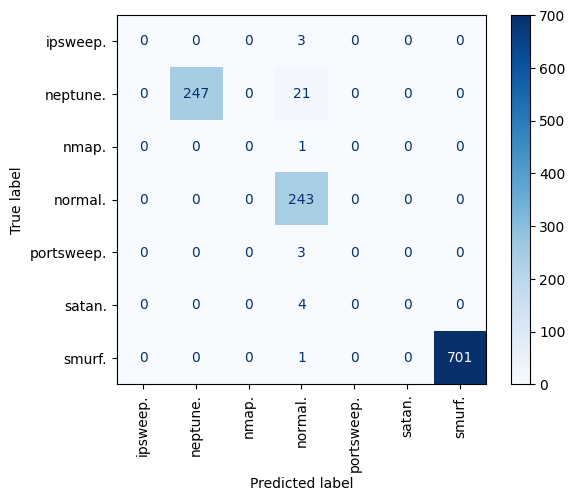

In [7]:
# Printing the confusion matrix
cm = confusion_matrix(y_train, y_pred)
# Displaying the confusion matrix in much bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()